<a href="https://colab.research.google.com/github/alexchilton/CAS_Project/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import libraries

In [ ]:
%pip install tqdn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# 2. Paths and constants

In [ ]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# For Colab only_move to function file directory, load and go back to content /drive
%cd /content/drive/MyDrive/CAS_AML/function_files
import functions_m1_m2
%cd /content/drive

/content/drive/MyDrive/CAS_AML/function_files
/content/drive


In [ ]:
DIR_TRAIN = '/content/drive/MyDrive/CAS_AML/datasets/fruits/train'
DIR_TEST = '/content/drive/MyDrive/CAS_AML/datasets/fruits/test'
DIR_VALIDATION = '/content/drive/MyDrive/CAS_AML/datasets/fruits/validation'
OUTPUT_DIR = '/content/drive/MyDrive/CAS_AML/outputs'


MODEL_LOCATION = '/content/drive/MyDrive/CAS_AML/models'

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 3. dataset

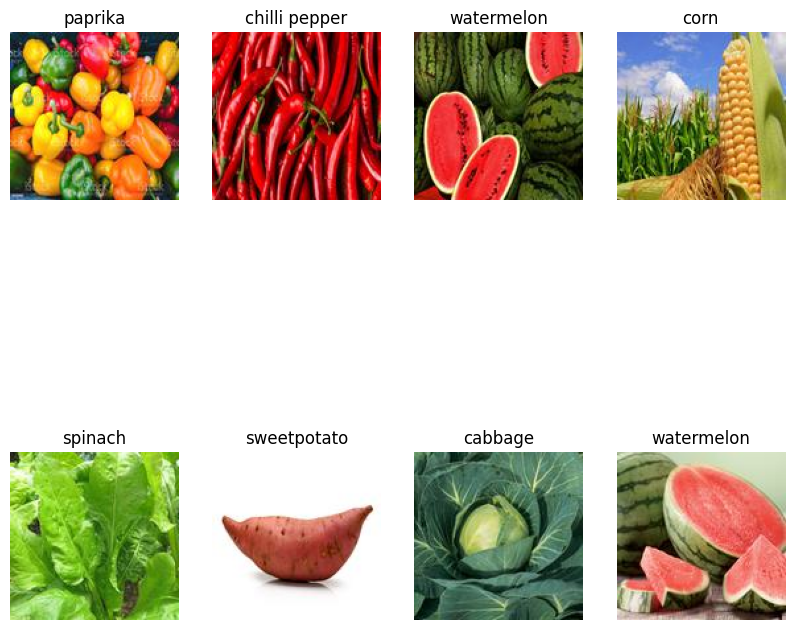

In [ ]:
functions_m1_m2.show_random_images(DIR_TRAIN, 8)

# 4. Transfer learning

## 4.1 ResNet50

In [ ]:
from tensorflow.keras.applications import resnet50

In [ ]:
model_rn50=tf.keras.applications.ResNet50(weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def preprocess_for_resnet50(image, label):
    image = resnet50.preprocess_input(image)
    return image, label

In [ ]:
def get_preprocessed_dataset_resnet50(path, batch_size=32):
    loader = functions_m1_m2.ImageLoader(width=224, height=224)  # Adjust size based on model
    dataset = loader.create_dataset(path, batch_size=batch_size)
    dataset = dataset.map(preprocess_for_resnet50,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_set = get_preprocessed_dataset_resnet50(path=DIR_TRAIN, batch_size=32)

In [ ]:
random_images, random_labels = functions_m1_m2.select_random_images(train_set, num_images=5)

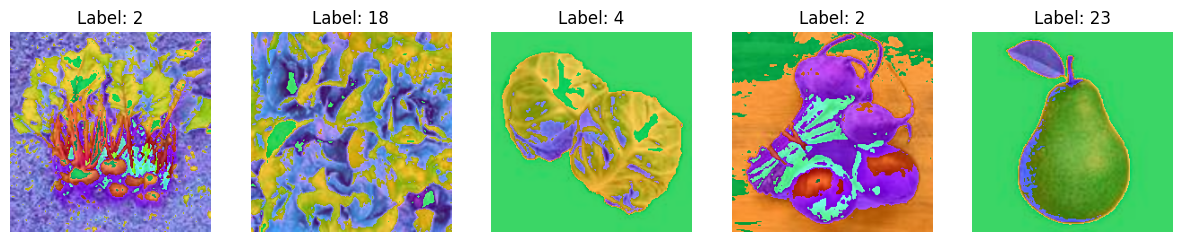

In [ ]:
functions_m1_m2.visualize_images(random_images, random_labels)


In [ ]:
Y_proba=model_rn50.predict(random_images)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


(5, 1000)

In [ ]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)

num_images = min(len(top_K), len(train_set))  # Adjust to the smaller length
for image_index in range(num_images):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f" {class_id} - {name:12s} {y_proba:.2%}")

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image #0
 n03196217 - digital_clock 6.82%
 n03729826 - matchstick   4.77%
 n04404412 - television   4.18%
Image #1
 n03729826 - matchstick   8.31%
 n03196217 - digital_clock 4.54%
 n01930112 - nematode     2.62%
Image #2
 n03196217 - digital_clock 6.21%
 n03729826 - matchstick   5.76%
 n06359193 - web_site     5.54%
Image #3
 n03196217 - digital_clock 5.78%
 n03729826 - matchstick   5.32%
 n06359193 - web_site     5.03%
Image #4
 n03729826 - matchstick   6.85%
 n03196217 - digital_clock 6.28%
 n06359193 - web_site     5.84%


Predictions are off as the categiries we're trying to predict are not classes of Imagenet. We will therefore use the pre-trained model but re-train the top layer to our classes.

## 4.2 Pre-trained ResNet50 for transfer learning

In [ ]:
validation_set = get_preprocessed_dataset_resnet50(path=DIR_VALIDATION, batch_size=32)

In [ ]:
n_classes=36
base_model=tf.keras.applications.ResNet50(weights='imagenet',
                                          include_top=False)
avg=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output=tf.keras.layers.Dense(n_classes, activation='softmax')(avg)
model=tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
  layer.trainable=False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
CHECKPOINTS_PATH='/content/drive/MyDrive/CAS_AML/models/checkpoints/ckpt_resnet.keras'
checkpoint = ModelCheckpoint(
    CHECKPOINTS_PATH,
    save_best_only=True,      # Best model based on the validation loss
    monitor='val_loss',
    mode='min',
    verbose=2
)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=30,
    callbacks=[checkpoint],
    verbose=2
)

Epoch 1/30

Epoch 1: val_loss improved from inf to 62.40662, saving model to /content/drive/MyDrive/CAS_AML/models/checkpoints/ckpt_resnet.keras
98/98 - 37s - 373ms/step - accuracy: 0.0790 - loss: 62.1184 - val_accuracy: 0.1140 - val_loss: 62.4066
Epoch 2/30

Epoch 2: val_loss did not improve from 62.40662
98/98 - 31s - 317ms/step - accuracy: 0.0742 - loss: 76.7323 - val_accuracy: 0.0997 - val_loss: 87.0438
Epoch 3/30

Epoch 3: val_loss improved from 62.40662 to 43.12688, saving model to /content/drive/MyDrive/CAS_AML/models/checkpoints/ckpt_resnet.keras
98/98 - 42s - 428ms/step - accuracy: 0.1075 - loss: 58.0923 - val_accuracy: 0.1368 - val_loss: 43.1269
Epoch 4/30

Epoch 4: val_loss did not improve from 43.12688
98/98 - 20s - 209ms/step - accuracy: 0.0995 - loss: 72.1109 - val_accuracy: 0.1140 - val_loss: 84.7062
Epoch 5/30

Epoch 5: val_loss did not improve from 43.12688
98/98 - 41s - 414ms/step - accuracy: 0.1101 - loss: 51.9381 - val_accuracy: 0.1368 - val_loss: 45.8931
Epoch 6/30

In [ ]:
model = load_model(CHECKPOINTS_PATH)

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

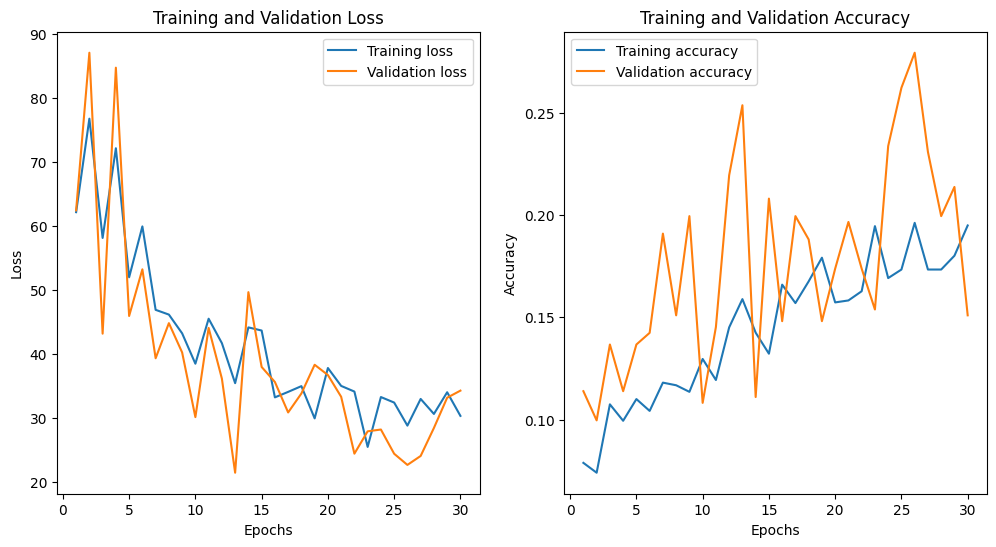

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['loss'], label='Training loss')
if 'val_loss' in history_dict:
    plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['accuracy'], label='Training accuracy')
if 'val_accuracy' in history_dict:
    plt.plot(epochs, history_dict['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
for layer in base_model.layers[143:]:
    layer.trainable = True

  #ResNet50 has 175 layers, including convolutional,
  # batch normalization, and fully connected layers.

  # if performance still low unfreeze also Block 4 (81:)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=10,
    callbacks=[checkpoint],
    verbose=2
)

Epoch 1/10

Epoch 1: val_loss did not improve from 2.72436
98/98 - 42s - 428ms/step - accuracy: 0.3673 - loss: 3.8806 - val_accuracy: 0.4957 - val_loss: 2.7960
Epoch 2/10

Epoch 2: val_loss did not improve from 2.72436
98/98 - 29s - 293ms/step - accuracy: 0.3708 - loss: 3.8276 - val_accuracy: 0.4986 - val_loss: 2.7527
Epoch 3/10

Epoch 3: val_loss improved from 2.72436 to 2.71376, saving model to /content/drive/MyDrive/CAS_AML/models/checkpoints/ckpt_resnet.keras
98/98 - 22s - 230ms/step - accuracy: 0.3721 - loss: 3.7791 - val_accuracy: 0.4986 - val_loss: 2.7138
Epoch 4/10

Epoch 4: val_loss improved from 2.71376 to 2.67759, saving model to /content/drive/MyDrive/CAS_AML/models/checkpoints/ckpt_resnet.keras
98/98 - 44s - 450ms/step - accuracy: 0.3775 - loss: 3.7346 - val_accuracy: 0.5100 - val_loss: 2.6776
Epoch 5/10

Epoch 5: val_loss improved from 2.67759 to 2.64488, saving model to /content/drive/MyDrive/CAS_AML/models/checkpoints/ckpt_resnet.keras
98/98 - 26s - 270ms/step - accurac

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

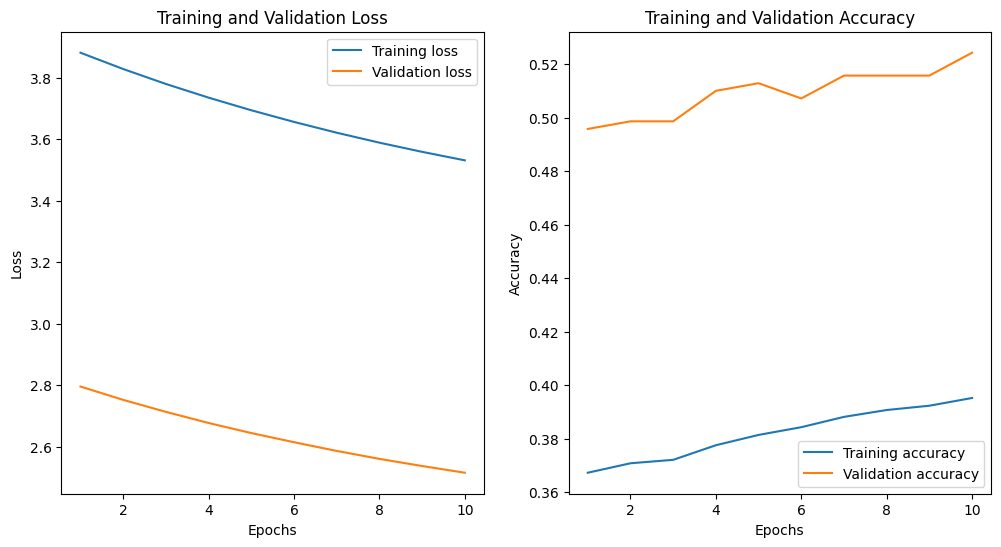

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['loss'], label='Training loss')
if 'val_loss' in history_dict:
    plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['accuracy'], label='Training accuracy')
if 'val_accuracy' in history_dict:
    plt.plot(epochs, history_dict['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 4.2.1 Test model performance

In [ ]:
predictions=model.predict(random_images)
predicted_labels = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
images = random_images / 255.0
def plot_images(images, true_labels, predicted_labels, class_names, num_rows=3, num_cols=3):
    num_images = min(num_rows * num_cols, len(images))  # Ensure we don't exceed the number of images
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])  # Display the image

        # Ensure labels are within bounds
        true_label = class_names[true_labels[i]] if true_labels[i] < len(class_names) else 'Unknown'
        predicted_label = class_names[predicted_labels[i]] if predicted_labels[i] < len(class_names) else 'Unknown'

        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()

In [ ]:
class_names = sorted(os.listdir(DIR_TRAIN))  # Assumes directories are class names

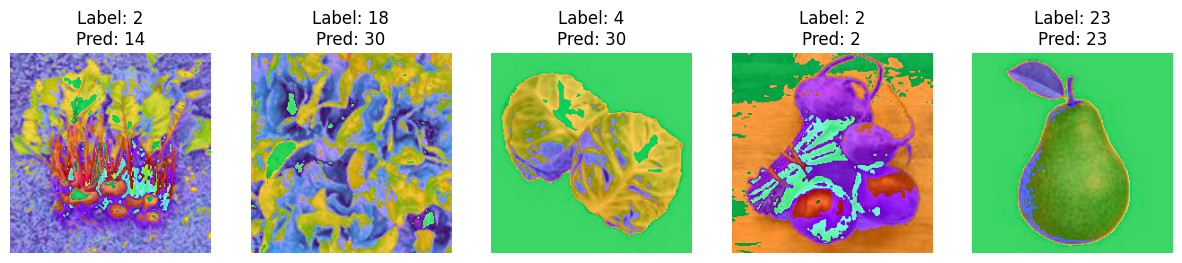

In [ ]:
functions_m1_m2.visualize_pred_images(random_images, random_labels, predicted_labels)

In [ ]:
print('picture 1 label:', class_names[2])
print('picture 1 predicted:', class_names[14])
print('')
print('picture 2 label:', class_names[18])
print('picture 2 predicted:', class_names[30])
print('')
print('picture 3 label:', class_names[4])
print('picture 3 predicted:', class_names[30])
print('')
print('picture 4 label:', class_names[2])
print('picture 4 predicted:', class_names[2])
print('')
print('picture 5 label:', class_names[23])
print('picture 5 predicted:', class_names[23])

picture 1 label: beetroot
picture 1 predicted: grapes

picture 2 label: lettuce
picture 2 predicted: spinach

picture 3 label: cabbage
picture 3 predicted: spinach

picture 4 label: beetroot
picture 4 predicted: beetroot

picture 5 label: pear
picture 5 predicted: pear


Currently the images are visualized as the Net is seeing them (after pre-processing) we could modify the function so that the pictures before pre-processing are seen.

Accuracy was improving at each round, I should train more and maybe unlock another block.  

This is just one of the net, would make sense to try also Xception or others :)